# Auto-Validation


In [175]:
import pdal 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree, cKDTree
from scipy.linalg import svd 
from osgeo import ogr
import pyvista as pv
import os
import csv
import time 
import matplotlib.pyplot as plt
import copy

import open3d as o3d
from interessant import * # Bei Änderungen Kernel neu starten


ogr.UseExceptions()

In [176]:
clusterexamples = [
    "PunkteSeiteVieleAusreisser",
    "ObenundSeite", # In Wirklichkeit nur oben
    "ObenNull1",
    "PunkteSeite",
    "VieleLückeMitte",
    "VieleGleiseEherTop", # Übergang
    "VieleSchürhaken",
    "VieleZ", # Fast nur auf Seite, schrott
    "Achszaehler1",
    "Achszaehler2",
    "Achszaehler3",
    "Auch links rechts falsch",
    "PunkteOben",
    "ObenNull",
    "ObenNull2",
    "ObenNull3",
    "Abseits1",
    "Abseits14Punkte",
    "AbseitsAusreisser",
    "VSeite1",
    "VSeite2",
    "VSeite3",
    "VSeite4", # Ausreisser
    "VSeite5"
]

useclusterexamples = True

In [177]:
tmpdir = "/media/riannek/minimax/gleis/temp_fertig"

# Bahnsteig: 29; Gleis hohe Intensität: 11; Weiche B: 16; Unterirdischer Bhf: 20; Gleis weit abseits: 23; Betondeckel: 28; Zug run 14 A: 6; 
# Viele Gleise: 33; Anfang Weiche: 34; OLA gleiche H: 35; Y: 37; Auch viele Gleise: 43; Kreuzung: 44, 45;

key = list(interessant.keys())[23] 

filename = interessant[key]
filename = filename.split(".")[0] + ".ply"
print(key, filename)


if not os.path.exists(os.path.join(tmpdir, filename)):
    raise FileNotFoundError(filename)

Gleis weit abseits 4473625_5337975.ply


In [178]:
thresh_side_distance = 0.15   # 0.1 ist meist gut, aber in manchen Fällen zu wenig (z.B. Anfang Weiche)

intensity_threshold = 14500
downsample_radius = 0.45 # 0.4
neighborhood_radius = 0.5 # 0.5

min_points = 10
minimum_in_hood = 10
linearity_tresh = 0.98

gauge = 1.435
railhead_width = 0.067

In [179]:
runfolder = "/media/riannek/minimax/gleis/run24-2024-08-13"

import subprocess
# subprocess.Popen(["pyvistaviewer", os.path.join(runfolder, filename.split(".")[0] + ".copc.laz")])

## Laden

In [180]:
gpkg = ogr.Open(os.path.join(tmpdir, "temp.gpkg"))
layer = gpkg.GetLayerByName("tiles")

In [181]:
def extend_bbox(bbox, margin=2):
    # MinX, MaxX, MinY, MaxY
    return (bbox[0] - margin, bbox[1] + margin, bbox[2] - margin, bbox[3] + margin)

def get_bbox_polygon(bbox):  
    ring = ogr.Geometry(ogr.wkbLinearRing)      
    ring.AddPoint_2D(bbox[0], bbox[2])  # MinX, MinY
    ring.AddPoint_2D(bbox[1], bbox[2])  # MaxX, MinY
    ring.AddPoint_2D(bbox[1], bbox[3])  # MaxX, MaxY
    ring.AddPoint_2D(bbox[0], bbox[3])  # MinX, MaxY
    ring.AddPoint_2D(bbox[0], bbox[2])  # Close ring
    geom = ogr.Geometry(ogr.wkbPolygon)
    geom.AddGeometry(ring)
    return geom

In [182]:
filter = f"filename = '{filename}'"
layer.SetAttributeFilter(filter)
feature = layer.GetNextFeature()
layer.SetAttributeFilter(None)
bbox = feature.GetGeometryRef().GetEnvelope()
extended = extend_bbox(bbox, margin=2)
bbox_geom = get_bbox_polygon(extended)
layer.SetSpatialFilter(bbox_geom)
tiles = [f.GetField("filename") for f in layer]
layer.SetSpatialFilter(None) 

print(tiles) 

['4473650_5337950.ply', '4473650_5337975.ply', '4473625_5337975.ply', '4473625_5338000.ply', '4473650_5338000.ply', '4473625_5337950.ply']


In [183]:
bbox # MinX, MaxX, MinY, MaxY

(4473633.296, 4473650.0, 5337975.0, 5338000.0)

In [184]:
del gpkg

In [185]:
bounds = f"([{extended[0]}, {extended[1]}], [{extended[2]}, {extended[3]}])" 
bounds

'([4473631.296, 4473652.0], [5337973.0, 5338002.0])'

In [186]:
readers = [pdal.Reader(os.path.join(tmpdir, tile)) for tile in tiles]
pipeline = pdal.Pipeline(readers) | pdal.Filter.merge() | pdal.Filter.crop(bounds=bounds)
pipeline.execute()
points = pipeline.arrays[0]
points.shape 

(6332,)

In [187]:
low_intensity = points[points["Intensity"] < intensity_threshold]
low_intensity.shape

(5180,)

In [188]:
bounds = f"([{bbox[0]}, {bbox[1]}], [{bbox[2]}, {bbox[3]}])" 
bounds

'([4473633.296, 4473650.0], [5337975.0, 5338000.0])'

In [189]:
# Downsample with poisson sampling (only original bbox)

downsampling_pipeline = pdal.Filter.crop(bounds=bounds).pipeline(low_intensity) | pdal.Filter("filters.sample", radius=downsample_radius)
downsampling_pipeline.execute()
seed_points = downsampling_pipeline.arrays[0]
seed_point_count = seed_points.shape[0]
seed_point_count

178

In [190]:
xyz = np.vstack((points['X'], points['Y'], points['Z'])).transpose()
xyz_seed = np.vstack((seed_points['X'], seed_points['Y'], seed_points['Z'])).transpose()

In [191]:
offset = xyz.mean(axis=0).round() 
xyz -= offset
xyz_seed -= offset

In [192]:
tree = KDTree(xyz)  

# indices: ndarray (dtype object) with a list of indices for each seed point
indices = tree.query_ball_point(xyz_seed, r=neighborhood_radius, workers=-1)

In [193]:
def pca(cloud):
    """Use PCA to get einvalues and eigenvectors of a point cloud
    
    Returns (eigenvalues, eigenvectors)
    """
    if cloud.shape[0] < 3:
        raise ValueError("Point cloud must have at least 3 points")
    mean = np.mean(cloud, axis=0)
    centered = cloud - mean
    U, S, Vt = svd(centered, full_matrices=False)
    eigenvals = S**2/(cloud.shape[0]-1)
    # Returned vectors are in columns, first vector is eigenvec[:, 0] == eigenvec.T[0]
    return eigenvals, Vt.T

In [194]:
def dbscan_stretchz(xyz, min_points=10, stretch=1.5):

    pointcount = xyz.shape[0]
    if pointcount <= min_points:
        return np.ones(pointcount, dtype=np.int8) * -1
    
    eps = 50 / pointcount
    eps = max(eps, 0.06)
    
    xyz = xyz.copy()
    xyz[:, 2] *= stretch
    hood_pcd = o3d.geometry.PointCloud()
    hood_pcd.points = o3d.utility.Vector3dVector(xyz) 
    # eps is min distance between clusters
    labels = np.array(hood_pcd.cluster_dbscan(eps=eps, min_points=min_points, print_progress=False))
    return labels



In [195]:
def plot_first_eigenvec(point, eigenvects, color=[1, 0, 0], stretch=1):
    """Plot a vector as a line"""
    vector = eigenvects.T[0] * stretch
    end = point + vector
    line = o3d.geometry.LineSet()
    line.points = o3d.utility.Vector3dVector([point, end])
    line.lines = o3d.utility.Vector2iVector([[0, 1]])
    line.colors = o3d.utility.Vector3dVector([color])
    return line

In [196]:
def plot_cluster_line(cluster, eigenvects, stretch=0.2):
    start = cluster.mean(axis=0)
    vector = eigenvects.T[0] * stretch
    end = start + vector
    line = pv.Line(start, end)

    return line

In [197]:
def plot_cluster(cluster, eigenvects=None): 
    center = cluster.mean(axis=0)
    centered = cluster - center

    if eigenvects is None:
        eigenvals, eigenvects = pca(cluster)

    transformed = centered @ eigenvects
    fig, ax = plt.subplots(figsize=(10, 15))
    ax.scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax.set_aspect("equal")
    plt.show()
    return fig, ax

In [198]:
def to_color(skalar, cmap=plt.cm.plasma):
    return cmap(skalar)[:3]

In [199]:
def get_central_point(a, b):
    """Get the point in the middle of two points"""
    vector = b - a
    return a + vector / 2

In [200]:
def plot_cluster(cluster, eigenvects=None): 
    center = cluster.mean(axis=0)
    centered = cluster - center

    if eigenvects is None:
        eigenvals, eigenvects = pca(cluster)

    transformed = centered @ eigenvects
    fig, ax = plt.subplots(figsize=(10, 15))
    ax.scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax.set_aspect("equal")
    plt.show()
    return fig, ax
    

In [201]:
def cluster_is_on_top(cluster, clustercenter, points):
    """Check that there are no points above the cluster center"""
    x_min, x_max = clustercenter[0] - 0.05, clustercenter[0] + 0.05
    y_min, y_max = clustercenter[1] - 0.05, clustercenter[1] + 0.05
    z_min = cluster[:,2].max()

    mask = ((points[:, 0] > x_min) & 
        (points[:, 0] < x_max) & 
        (points[:, 1] > y_min) & 
        (points[:, 1] < y_max) & 
        (points[:, 2] > z_min))
    
    
    return points[mask].shape[0] == 0

In [202]:
def plot_cluster_pair(cluster, cluster_other, transformmatrix, percentile=95, railhead_width = 0.067, centering="cluster", point_this=None, point_other=None): 
    """Plot pair of clusters in the PCA coordinate system of the pair 
    
    Args:
        cluster (np.array): Cluster of points
        cluster_other (np.array): Other cluster of points
        eigenvects (np.array): Eigenvectors of the PCA of the pair of clusters
        percentile (int): Percentile of the height for the horizontal line
        railhead_width (float): Width of the railhead (0.067 or 0.072)
        centering (str): "cluster" or "pair"
    """
    center = (cluster.sum(axis=0) + cluster_other.sum(axis=0)) / (cluster.shape[0] + cluster_other.shape[0])
    center_cluster = cluster.mean(axis=0)
    center_other = cluster_other.mean(axis=0)

    if centering == "cluster":
        cluster = cluster - center_cluster
        cluster_other = cluster_other - center_other
        point_this = point_this - center_cluster
        point_other = point_other - center_other
    else:
        cluster = cluster - center
        cluster_other = cluster_other - center
        point_this = point_this - center
        point_other = point_other - center

    transformed = cluster @ transformmatrix
    transformed_other = cluster_other @ transformmatrix
    #print("center", center)
    #print(center_cluster - center, center_other - center)
    #print((center_cluster - center) @ transformmatrix, (center_other - center) @ transformmatrix)


    # Check if we need to switch the left, right cluster
    center_cluster_in_pc = (center_cluster - center) @ transformmatrix
    center_other_in_pc = (center_other - center) @ transformmatrix
    if center_cluster_in_pc[0] > center_other_in_pc[0]:
        transformed, transformed_other = transformed_other, transformed
        point_this, point_other = point_other, point_this
        # print("Switched clusters")

    fig, ax = plt.subplots(1,2, figsize=(15, 7))

    if centering == "cluster":
        ax[0].set_ylim(-0.08, 0.06)
        ax[1].set_ylim(-0.08, 0.06)
    else:
        ax[0].set_xlim(-0.85, -0.65)
        ax[0].set_ylim(-0.08, 0.06)
        ax[1].set_xlim(0.65, 0.85)
        ax[1].set_ylim(-0.08, 0.06)
        ax[0].axvline(-gauge/2, color="lightgrey", linestyle="-", zorder=-1)
        ax[0].axvline(-gauge/2 - railhead_width, color="lightgrey", linestyle="-", zorder=-1)
        ax[1].axvline(gauge/2, color="lightgrey", linestyle="-", zorder=-1)
        ax[1].axvline(gauge/2 + railhead_width, color="lightgrey", linestyle="-", zorder=-1)

    ax[0].scatter(transformed[:,0], transformed[:,2], c=transformed[:,1], cmap=plt.cm.plasma, marker=".")
    ax[0].set_aspect("equal")

    x_mean = transformed[:,0].mean()
    ax[0].axvline(x_mean, color="forestgreen", linestyle="--", zorder=-1)
    ax[0].axvline(x_mean - (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[0].axvline(x_mean + (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[0].axhline(np.percentile(transformed[:,2], percentile), color="forestgreen", linestyle="--", zorder=-1)
    ax[0].axhline(transformed[:,2].mean(), color="forestgreen", linestyle="--", zorder=-1)

    ax[1].scatter(transformed_other[:,0], transformed_other[:,2], c=transformed_other[:,1], cmap=plt.cm.plasma, marker=".")
    ax[1].set_aspect("equal")

    x_mean = transformed_other[:,0].mean()
    ax[1].axvline(x_mean, color="forestgreen", linestyle="--", zorder=-1)
    ax[1].axvline(x_mean - (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[1].axvline(x_mean + (railhead_width/2), color="lightgreen", linestyle="--", zorder=-1)
    ax[1].axhline(np.percentile(transformed_other[:,2], percentile), color="forestgreen", linestyle="--", zorder=-1)
    ax[1].axhline(transformed_other[:,2].mean(), color="forestgreen", linestyle="--", zorder=-1)

    if point_this is not None:
        point_this_transformed = point_this  @ transformmatrix
        ax[0].axvline(point_this_transformed[0], color="red", linestyle="--", zorder=-1)
        ax[0].axhline(point_this_transformed[2], color="red", linestyle="--", zorder=-1)
        ax[0].axvline(point_this_transformed[0] - (railhead_width/2), color="tomato", linestyle="--", zorder=-1)
        ax[0].axvline(point_this_transformed[0] + (railhead_width/2), color="tomato", linestyle="--", zorder=-1)
        ax[0].annotate(f"{point_this_transformed[0]:.5f}", xy=(point_this_transformed[0], point_this_transformed[2]), xytext=(point_this_transformed[0] + 0.01, point_this_transformed[2] + 0.01), fontsize=10, color="red", ha="left", va="bottom")

    if point_other is not None:
        point_other_transformed = point_other  @ transformmatrix
        ax[1].axvline(point_other_transformed[0], color="red", linestyle="--", zorder=-1)
        ax[1].axhline(point_other_transformed[2], color="red", linestyle="--", zorder=-1)
        ax[1].axvline(point_other_transformed[0] - (railhead_width/2), color="tomato", linestyle="--", zorder=-1)
        ax[1].axvline(point_other_transformed[0] + (railhead_width/2), color="tomato", linestyle="--", zorder=-1)
        ax[1].annotate(f"{point_other_transformed[0]:.5f}", xy=(point_other_transformed[0], point_other_transformed[2]), xytext=(point_other_transformed[0] + 0.01, point_other_transformed[2] + 0.01), fontsize=10, color="red", ha="left", va="bottom")

    plt.show()
    return fig, ax, transformed, transformed_other




In [203]:
def which_side(cluster):
    """Check which on which side of the rail the transformed cluster is
    
    Returns a value between -1 and 1, positive values if points are on the 
    right side of the rail, and negative values for the left side. 
    The absolute value is kind of the confidence of the estimation.
    """

    # Count the points below the centroid, on the left and the right side 
    # but only within half the width of the railhead 

    left_mask = (cluster[:,2] < 0) & (cluster[:,0] < 0) & (cluster[:,0] > -railhead_width/2)
    right_mask = (cluster[:,2] < 0) & (cluster[:,0] > 0) & (cluster[:,0] < railhead_width/2)
    left_count = np.sum(left_mask)
    right_count = np.sum(right_mask)
    both_count = left_count + right_count
    if both_count == 0:
        return 0
    return (left_count - right_count) / both_count

In [204]:
##### noinverse nur für Validierung

def representive_point_3(cluster, transformmatrix, upperpercentile=90, lowerpercentile=70, railhead_width=0.067, side=None, noinverse=False):
    """Version 3

    Unterschied bei "Vor allem Top": 
        min und max x bei z>-0.01
        lowerpercentile des oberen Teils für z
    """


    center = cluster.mean(axis=0)
    centered = cluster - center
    transformed = centered @ transformmatrix
    max_z = transformed[:,2].max()

    if max_z < 0.03:
        # This happens if most points are on the top of the rail (usually max_z close to 0.02)
        # Calculate the mean of the range for points above -0.01
        # (this makes sure we get the approx. railhead width)
        transformed_x_upper = transformed[transformed[:,2] > -0.01][:,0]
        center_x = (transformed_x_upper.max() + transformed_x_upper.min()) / 2
        # only consider points above the centroid
        center_z = np.percentile(transformed[transformed[:,2] > 0][:,2], lowerpercentile)
        side = 0
    else:
        # Many points are on the side of the rail (usually the max_z around 0.04)
        # but we need check which side 

        if side is None:
            side = which_side(transformed)

        # x values of points above the centroid
        # (there might be outliers in the lower part of the cluster)
        transformed_x_upper = transformed[transformed[:,2] > 0][:,0]

        if side < 0:
            # left side
            # Only consider one quadrant in the transformed space
            # This makes clusters with more or less points on the rail top more comparable
            min_x = np.percentile(transformed_x_upper[transformed_x_upper < 0],100-lowerpercentile)
            center_x = min_x + railhead_width / 2
        else:
            max_x = np.percentile(transformed_x_upper[transformed_x_upper > 0],lowerpercentile)
            center_x = max_x - railhead_width / 2 
        center_z = np.percentile(transformed[transformed[:,2] > 0][:,2], upperpercentile)

    
    transformed_representive = np.array([center_x, 0, center_z])

    if noinverse:
        return transformed_representive, side

    return transformed_representive @ transformmatrix.T + center, side

In [205]:
def get_transformmatrix(cluster, cluster_other, clustercenter, clustercenter_other, eigenvects):
    # Use the top part of the rail clusters to circumvent the problem different point distributions
    top = cluster[:,2].max()
    top_other = cluster_other[:,2].max()
    topcenter = np.array([clustercenter[0], clustercenter[1], top])
    topcenter_other = np.array([clustercenter_other[0], clustercenter_other[1], top_other])
    sidevector = topcenter - topcenter_other
    # Project on the plane perpendicular to the first eigenvector
    # (eigenvects are normalized)
    projection_on_first_eig = (sidevector @ eigenvects.T[0]) * eigenvects.T[0]
    sidevector_perpendicular = sidevector - projection_on_first_eig
    sidevector_perpendicular = sidevector_perpendicular / np.linalg.norm(sidevector_perpendicular)
    normal = np.cross(sidevector_perpendicular, eigenvects.T[0]) 

    matrix = np.array([sidevector_perpendicular, eigenvects.T[0], normal]).T

    if normal[2] < 0:
        Rx_180 = np.array([
            [1,  0,  0],
            [0, -1,  0],
            [0,  0, -1]
        ])
        # Data in row vector, this is first the main rotation, than the rotation around the y axis
        matrix = matrix @ Rx_180 

    return matrix

In [206]:
def draw_registration_result(source, target, transformation):
    axes = axes = o3d.geometry.TriangleMesh().create_coordinate_frame(size=0.1)
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp, axes])


In [207]:
def load_clusters(preset):
    fileleft = f"clusterbeispiele/{preset}_l.ply"
    fileright = f"clusterbeispiele/{preset}_r.ply"
    filepair = f"clusterbeispiele/{preset}_pair.ply"
    if not os.path.exists(fileleft):
        raise FileNotFoundError(f"File {fileleft} not found")
    cluster = o3d.io.read_point_cloud(fileleft)
    cluster_other = o3d.io.read_point_cloud(fileright)
    cluster_pair = o3d.io.read_point_cloud(filepair)
    return np.asarray(cluster.points) , np.asarray(cluster_other.points), np.asarray(cluster_pair.points)

In [208]:
def cluster_generator(points, min_points):
    if points.shape[0] < min_points:
        return
    
    labels = dbscan_stretchz(points, min_points=min_points, stretch=4)
    max_label = labels.max()
    
    for label in range(max_label + 1):
        cluster = points[labels == label]
        if cluster.shape[0] < min_points:
            # Somehow this happens, must be a bug in open3d
            continue

        eigenvals, eigenvects = pca(cluster)
        cluster_linearity = linearity(eigenvals)


        if not ((cluster_linearity > linearity_tresh) and (eigenvals[0] > 0.04)):
            # Cluster not linear or too short
            continue

        clustercenter = cluster.mean(axis=0)

        # Make sure there are no points above the cluster
        # (exclude clusters at the base of the track profile)
        if not cluster_is_on_top(cluster, clustercenter, points):
            continue
        

        yield cluster, clustercenter, eigenvals, eigenvects


def check_cluster_for_railpair(clustercenter, eigenvects, pointcloud, tree, gauge, min_points):

    # Check for rail pair
    sidevector = np.cross(eigenvects[:,0], np.array([0, 0, 1])) * (gauge + 0.07) # Add railtop width to gauge
    bothsides = np.array([clustercenter + sidevector, clustercenter - sidevector])

    indices_bothsides = tree.query_ball_point(bothsides, r=neighborhood_radius)
    
    # Linear cluster that is closest to one of the estimated side points (ignoring z)
    # but must me within r = 15 cm and almost parallel

    closest_cluster_distance = np.inf
    closest_cluster = None
    closest_cluster_center = None
    
    for j, side in enumerate(indices_bothsides):
        for sidecluster, sideclustercenter, _, eigenvects_side in cluster_generator(pointcloud[side], min_points):
            
            # Check distance
            sidecluster_distance = np.linalg.norm(sideclustercenter[:2] - bothsides[j][:2]) # only xy
            if sidecluster_distance < thresh_side_distance and sidecluster_distance < closest_cluster_distance:
                # Check if parallel
                cos_angle = np.abs(np.dot(eigenvects[:,0], eigenvects_side[:,0]))
                if cos_angle > 0.9:  
                    closest_cluster = sidecluster
                    closest_cluster_distance = sidecluster_distance
                    closest_cluster_center = sideclustercenter

    return closest_cluster, closest_cluster_center

In [209]:
def pair_generator():

    for i in range(seed_point_count):
        for cluster, clustercenter, eigenvals, eigenvects in cluster_generator(xyz[indices[i]], min_points=min_points):
            cluster_other, center_other = check_cluster_for_railpair(clustercenter, eigenvects, xyz, tree, gauge, min_points)
            if cluster_other is not None:
                yield cluster, clustercenter, cluster_other, center_other, eigenvects 

In [210]:
def get_o3d_transform(eigenvects, translation=None):
    """Create an open3d 4x4 transformation matrix from eigenvectors
    
    Version für 2 Schienen
    """
    eigenvects = eigenvects.copy()

    # Check if the last eigenvector is pointing down
    if eigenvects[2,2] < 0: # z of last eigenvector is negative
        # print("o3d trans was Upside down")
        # reflect
        eigenvects[:,2] *= -1 # reflection 

    # There is a 50% chance that det(eigenvects) is close to -1
    # (then the matrix includes a reflection)
    if np.linalg.det(eigenvects) < 0:
        # flip the first eigenvector
        eigenvects[:,0] *= -1


    transform = np.eye(4)
    transform[0:3, 0:3] = eigenvects

    if translation is not None:
        transform[:3, 3] = translation
    return transform

In [211]:
templatefiles = [
    "T_profil_ähnlich_54E4.ply", 
    "T_profil_ähnlich_54E4_schräg_random2.ply",
    "T_profil_ähnlich_54E4_schräg_random_wenig_punkte.ply"
    ]

In [212]:
def get_template(filename):
    shift = (gauge + railhead_width) / 2
    pcd = o3d.io.read_point_cloud(os.path.join("templates", filename))
    left = np.asarray(pcd.points)
    right = left.copy()
    left[:,0] -= shift
    right[:,0] += shift

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.vstack((left, right)))
    return pcd

In [213]:
def validate_registration(source, target, transformation,threshold=0.01, draw=False, crop=True, inverted=False, window_name="Validation"):
    """Validate the registration
    
    Source = the template
    Target = the point cloud of the cluster pair
    """
    source = copy.deepcopy(source)
    target = copy.deepcopy(target)
    source.transform(transformation)

    if inverted:
        # Template is target, point cloud the source
        target, source = source, target

    if crop:
        # Crop the target point cloud to the length of the template
        bbox = source.get_oriented_bounding_box()

        # make sure we only crop in the y direction of the oriented bounding box
        # x is the direction from left to right rail
        bbox_extent = np.array(bbox.extent) 
        bbox_extent[0] = 10
        bbox_extent[2] = 10

        bbox = o3d.geometry.OrientedBoundingBox(center=bbox.center, R=bbox.R, extent=bbox_extent)
        target = target.crop(bbox)

    total = len(target.points)

    if total == 0:
        if draw:
            target.paint_uniform_color([1, 0, 0])
            source.paint_uniform_color([1, 0.706, 0])
            axes = axes = o3d.geometry.TriangleMesh().create_coordinate_frame(size=0.1)
            o3d.visualization.draw_geometries([source, target, axes], window_name=window_name)
        return {
            "total": 0,
            "inliers": 0,
            "inlier_ratio": 0,
            "rmse_inliers": 0,
            "rmse_all": 0,
            "max_z_diff": 0,
        }

    # For each point of the cropped cluster, find the nearest point in the template
    # and check if it is within the threshold
    tree = cKDTree(np.asarray(source.points)) 
    neighbors = tree.query(np.asarray(target.points), k=1)
    dist = neighbors[0]
    inliers = dist < threshold 
    n_inliers = inliers.sum() 

    rmse_inliers = np.sqrt((dist[inliers]**2).mean())
    rmse_all = np.sqrt((dist**2).mean())

    max_z_diff = np.abs(np.asarray(target.points)[:,2].max() - np.asarray(source.points)[:,2].max())

    if draw:
        colors = np.zeros((len(target.points), 3))
        colors[inliers] = [0, 1, 0]
        colors[~inliers] = [1, 0, 0]
        target.colors = o3d.utility.Vector3dVector(colors)
        source.paint_uniform_color([1, 0.706, 0])
        axes = axes = o3d.geometry.TriangleMesh().create_coordinate_frame(size=0.1)
        o3d.visualization.draw_geometries([source, target, axes], window_name=window_name)


    return {
        "total": int(total),
        "inliers": float(n_inliers),
        "inlier_ratio": float(n_inliers / total),
        "rmse_inliers": float(rmse_inliers),
        "rmse_all": float(rmse_all),
        "max_z_diff": float(max_z_diff),
    }


In [214]:
def calculate_correlation(cluster, transformmatrix, inverse=False):

    cluster = cluster - cluster.mean(axis=0)
    transformmatrix = transformmatrix[0:3, 0:3] 
    if inverse:
        transformmatrix = transformmatrix.T

    transformed = cluster @ transformmatrix
    mask = transformed[:,2] > 0
    corr_xy = np.corrcoef(transformed[:,0], transformed[:,1])[0,1]
    corr_xy_upper = np.corrcoef(transformed[mask][:,0], transformed[mask][:,1])[0,1]
    corr_xy_lower = np.corrcoef(transformed[~mask][:,0], transformed[~mask][:,1])[0,1]
    corr_yz = np.corrcoef(transformed[:,1], transformed[:,2])[0,1]

    return {
        "corr_xy": np.abs(corr_xy),
        "corr_xy_upper": np.abs(corr_xy_upper),
        "corr_yz": np.abs(corr_yz),
       # "corr_xy_lower": np.abs(corr_xy_lower),
    }

In [215]:
def init_csv(folder, filename):
    """Initialize the CSV file with the header"""
    filename = os.path.join(folder, filename)
    print(os.path.abspath(filename))
    if os.path.exists(filename):
        return filename
    os.makedirs(folder, exist_ok=True)

    with open(filename,"w") as f:
        writer = csv.writer(f)
        writer.writerow([
            "file",
            "template",
            "cluster_id", 
            "how", 
            "direction",
            "shift_z",
            "total",
            "inliers", 
            "inlier_ratio", 
            "rmse_inliers", 
            "rmse_all", 
            "max_z_diff", 
            "corr_xy", 
            "corr_xy_upper", 
            "corr_yz",
            "max_corr",
            "icp_rmse",
            "icp_fitness",
            "side_a",
            "side_b",
            "not_same_side",
            "time"
            ])
    return filename

In [216]:
def validate(cluster_this, cluster_other, cluster_pair, name, cluster_id, filepath, threshold=0.02):
    _, eigenvects = pca(cluster_this)
    _, eigenvects_pair = pca(cluster_pair)

    center = get_central_point(cluster_this.mean(axis=0), cluster_other.mean(axis=0))
    centered = cluster_pair - center

    centered_pcd = o3d.geometry.PointCloud()
    centered_pcd.points = o3d.utility.Vector3dVector(centered)

    # Template 1 is used to validate ALL verions
    val_template = get_template(templatefiles[1])

    # First check my version
    source = copy.deepcopy(val_template)
    target = copy.deepcopy(centered_pcd)
    
    plottransform = get_transformmatrix(cluster_this, cluster_other, cluster_this.mean(axis=0), cluster_other.mean(axis=0), eigenvects)

    start = time.time()

    # The representive point is a translation relative to the transformmatrix 
    shift_a, side_a  = representive_point_3(cluster_this, plottransform, railhead_width=0.067, noinverse=True) 
    shift_b, side_b = representive_point_3(cluster_other, plottransform, railhead_width=0.067, noinverse=True)

    # Check if both are classified as the same side
    # but a zero and non zero value is not a problem
    if side_a * side_b < 0:
        # Update the cluster with lower confidence of the side estimation
        if np.abs(side_a) < np.abs(side_b):
            shift_a, side_a  = representive_point_3(cluster_this, plottransform, railhead_width=0.067, side=side_b, noinverse=True)
        else:
            shift_b, side_b = representive_point_3(cluster_other, plottransform,  railhead_width=0.067, side=side_a, noinverse=True)

    runtime = time.time() - start

    shift_mean = (shift_a + shift_b) / 2

    # Must shift template before rotation
    shift = np.eye(4)
    shift[0:3,3] = shift_mean
    source = copy.deepcopy(source)
    source.transform(shift)

    transform = np.eye(4)
    transform[0:3,0:3] = plottransform 

    result = validate_registration(source, target, transform)
    corr_this = calculate_correlation(cluster_this, transform)
    corr_other = calculate_correlation(cluster_other, transform)
    max_corr = max(max(corr_this.values()), max(corr_other.values()))

    with open(filepath, "a") as f:
        writer = csv.writer(f)
        writer.writerow([
            name,
            "", # Template number
            cluster_id,
            "My",
            "None",
            0, # Shift
            result["total"],
            result["inliers"],
            result["inlier_ratio"],
            result["rmse_inliers"],
            result["rmse_all"],
            result["max_z_diff"],
            corr_this["corr_xy"],
            corr_this["corr_xy_upper"],
            corr_this["corr_yz"],
            max_corr,
            "", # ICP RMSE
            "", # ICP Fitness
            side_a,
            side_b,
            int(side_a * side_b < 0),
            runtime,
        ])




    for templatenr, templatefile in enumerate(templatefiles): 
        template = get_template(templatefile)


        # With ICP
        variants = {
            "to_point": o3d.pipelines.registration.TransformationEstimationPointToPoint(),
            "to_plane": o3d.pipelines.registration.TransformationEstimationPointToPlane(),
        }

        for translation in [np.array([0, 0, 0]), np.array([0, 0, 0.03])]:
            for move_template in [True, False]:
                if move_template:
                    source = copy.deepcopy(template)
                    source_val = copy.deepcopy(val_template)
                    target = copy.deepcopy(centered_pcd)
                    target_val = target
                    trans_init = get_o3d_transform(eigenvects_pair, translation)
                    direction = "src=tem"
                else:
                    source = copy.deepcopy(centered_pcd)
                    source_val = source
                    target = copy.deepcopy(template)
                    target_val = copy.deepcopy(val_template)
                    trans_init = get_o3d_transform(eigenvects_pair.T, -translation)
                    direction = "src=pcl"
                    
                for variant, icp in variants.items(): 
                    start = time.time()
                    if variant == "to_plane":
                        # Compute normals
                        nn_distance = np.mean(target.compute_nearest_neighbor_distance()) 
                        radius_normals = nn_distance * 4
                        target.estimate_normals(
                            search_param=o3d.geometry.KDTreeSearchParamHybrid(
                                radius=radius_normals, 
                                max_nn=16), 
                            fast_normal_computation=True)

                    reg = o3d.pipelines.registration.registration_icp(
                        source, target, threshold, trans_init, icp)
                    
                    runtime = time.time() - start
                    
                    inverted = not move_template
                    result = validate_registration(source_val, target_val, reg.transformation, 0.01, inverted=inverted)
                    corr_this = calculate_correlation(cluster_this, reg.transformation, inverse=inverted)
                    corr_other = calculate_correlation(cluster_other, reg.transformation, inverse=inverted)
                    max_corr = max(max(corr_this.values()), max(corr_other.values()))

                    with open(filepath, "a") as f:
                        writer = csv.writer(f)
                        writer.writerow([
                            name,
                            templatenr,
                            cluster_id,
                            f"ICP {variant}",
                            direction,
                            translation[2],
                            result["total"],
                            result["inliers"],
                            result["inlier_ratio"],
                            result["rmse_inliers"],
                            result["rmse_all"],
                            result["max_z_diff"],
                            corr_this["corr_xy"],
                            corr_this["corr_xy_upper"],
                            corr_this["corr_yz"],
                            max_corr,
                            reg.inlier_rmse,
                            reg.fitness,
                            "",
                            "",
                            "",
                            runtime,
                        ])



In [217]:
folder = "validierung"

start = time.time()
cluster_id = 0

if useclusterexamples:
    filename = "clusterbeispielvalidierung.csv"
    filepath = init_csv(folder, filename)

    for preset in clusterexamples:
        cluster_this, cluster_other, cluster_pair = load_clusters(preset)
        validate(cluster_this, cluster_other, cluster_pair, preset, cluster_id, filepath)
        cluster_id += 1
else:
    filename = "validierung_dateien.csv"
    filepath = init_csv(filename)
    for cluster_this, clustercenter, cluster_other, center_other, eigenvects in pair_generator():
        cluster_pair = np.vstack((cluster_this, cluster_other))
        validate(cluster_this, cluster_other, cluster_pair, key, cluster_id, filepath)
        cluster_id += 1

print("Finished in", time.time() - start, "seconds")

/home/riannek/code/gleis/versuche/validierung/clusterbeispielvalidierung.csv


/tmp/ipykernel_25301/724189624.py:53: RuntimeWarning: Mean of empty slice.
  rmse_inliers = np.sqrt((dist[inliers]**2).mean())
/home/riannek/miniconda3/envs/points/lib/python3.9/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Finished in 52.63756203651428 seconds


In [218]:
raise ValueError("Stop here")

ValueError: Stop here

-0.9682539682539683 -0.992818671454219
Switched clusters


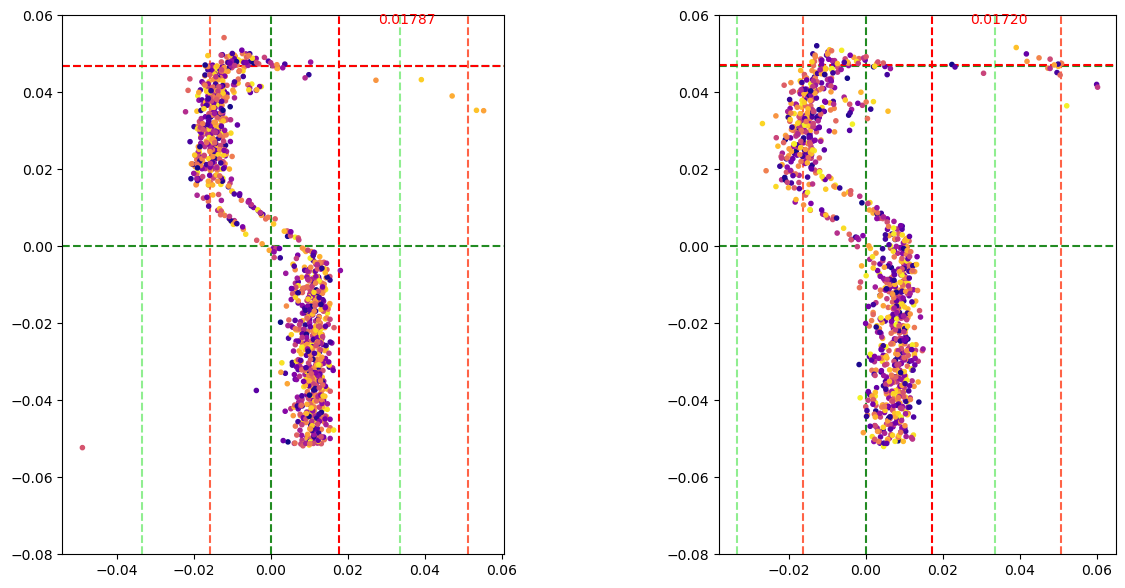

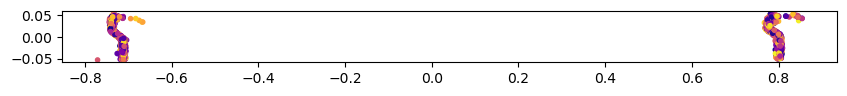

T_profil_ähnlich_54E4.ply


In [ ]:
preset = "VieleZ"

translation = translations[0]



cluster_this, cluster_other, cluster_pair = load_clusters(preset)
_, eigenvects = pca(cluster_this)
plottransform = get_transformmatrix(cluster_this, cluster_other, cluster_this.mean(axis=0), cluster_other.mean(axis=0), eigenvects)

point_this, side_a = representive_point_3(cluster_this, plottransform)
point_other, side_b = representive_point_3(cluster_other, plottransform)
print(side_a, side_b)
if side_a * side_b < 0:
    print("Different sides")
    # Update the cluster with lower confidence of the side estimation
    if np.abs(side_a) < np.abs(side_b):
        point_this, side_a  = representive_point_3(cluster_this, plottransform, railhead_width=0.067, side=side_b)
    else:
        point_other, side_b = representive_point_3(cluster_other, plottransform,  railhead_width=0.067, side=side_a)

plot_cluster_pair(cluster_this, cluster_other, plottransform, percentile=95, railhead_width = 0.067, centering="cluster", point_this=point_this, point_other=point_other);

plot_cluster(cluster_pair, plottransform);
print(templatefile)

In [ ]:
_, eigenvects_pair = pca(cluster_pair)

# center = cluster_pair.mean(axis=0) # Funktioniert nicht bei Lücke 
center = get_central_point(cluster_this.mean(axis=0), cluster_other.mean(axis=0))
centered = cluster_pair - center

centered_pcd = o3d.geometry.PointCloud()
centered_pcd.points = o3d.utility.Vector3dVector(centered)


print("Translation", translation)
trans_init = get_o3d_transform(eigenvects_pair, translation)

target = centered_pcd
source = get_template(templatefile)

o3d.visualization.draw_geometries([source, target], window_name="Initial configuration (NO TRANSFORM)")


print("Evaluate initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(
    source, target, threshold, trans_init)
print(evaluation)

print(validate_registration(source, target, trans_init, 0.01, draw=True, window_name="Initial transformation"))


if translation is None:
    tr_string = "None"
else:
    tr_string = str(translation[2])

# draw_registration_result(source, target, trans_init)

Translation None
o3d trans was Upside down
Evaluate initial alignment
RegistrationResult with fitness=2.401974e-01, inlier_rmse=1.458245e-02, and correspondence_set size of 3651
Access transformation to get result.
{'total': 983, 'inliers': 143.0, 'inlier_ratio': 0.14547304170905392, 'rmse_inliers': 0.006648313019235073, 'rmse_all': 0.026161573569350772, 'max_z_diff': 0.05359484912977337}


### Point to Point ICP

In [ ]:
start = time.time()
print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())
print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
print("Time:", time.time() - start)
print()
print(validate_registration(source, target, reg_p2p.transformation, 0.01, draw=True, window_name="Point-to-point ICP"))
print(f"{preset}_t{templatenr}_zTransf{tr_string}_point")

corr_this = calculate_correlation(cluster_this, reg_p2p.transformation)
corr_other = calculate_correlation(cluster_other, reg_p2p.transformation)
print("corr this",corr_this )
print("corr other", corr_other)
print("max corr", max(max(corr_this.values()), max(corr_other.values())))


# draw_registration_result(source, target, reg_p2p.transformation)

Apply point-to-point ICP
RegistrationResult with fitness=2.790132e-01, inlier_rmse=1.364070e-02, and correspondence_set size of 4241
Access transformation to get result.
Transformation is:
[[ 0.26662764  0.95512906  0.12898908  0.00468452]
 [-0.96378903  0.26485324  0.0310396  -0.00533118]
 [-0.00451635 -0.13259428  0.99116011  0.02102472]
 [ 0.          0.          0.          1.        ]]
Time: 0.0825796127319336

{'total': 335, 'inliers': 183.0, 'inlier_ratio': 0.5462686567164179, 'rmse_inliers': 0.005830798073354764, 'rmse_all': 0.01697292779497657, 'max_z_diff': 0.00910620518409927}
Achszaehler2_t0_zTransfNone_point
corr this {'corr_xy': np.float64(0.11691326898427484), 'corr_xy_upper': np.float64(0.07626431311531606), 'corr_yz': np.float64(0.7521880065727675)}
corr other {'corr_xy': np.float64(0.7462854955214779), 'corr_xy_upper': np.float64(0.7508529257745293), 'corr_yz': np.float64(0.742909314563991)}
max corr 0.7521880065727675


### Point to Plane ICP

In [ ]:
start = time.time()
print("Apply point-to-plane ICP")

# Point-to-plane ICP requires normals for the target
nn_distance = np.mean(target.compute_nearest_neighbor_distance())  
print("nn distance", nn_distance)  
  
#setting the radius search to compute normals  
radius_normals=nn_distance*4  
target.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16), fast_normal_computation=True)  

reg_p2l = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPlane())
print(reg_p2l)
print("Transformation is:")
print(reg_p2l.transformation)
print("Time:", time.time() - start)
print(validate_registration(source, target, reg_p2l.transformation, 0.01, draw=True, window_name="Point-to-plane ICP"))
print(f"{preset}_t{templatenr}_{tr_string}_plane")

corr_this = calculate_correlation(cluster_this, reg_p2l.transformation)
corr_other = calculate_correlation(cluster_other, reg_p2l.transformation)
print("corr this",corr_this )
print("corr other", corr_other)
print("max corr", max(max(corr_this.values()), max(corr_other.values())))

# draw_registration_result(source, target, reg_p2l.transformation)

Apply point-to-plane ICP
nn distance 0.007903435254969074
RegistrationResult with fitness=2.807237e-01, inlier_rmse=1.060341e-02, and correspondence_set size of 4267
Access transformation to get result.
Transformation is:
[[-4.68678816e-01  8.83367473e-01 -1.44010633e-03  1.52185332e-01]
 [-8.83365666e-01 -4.68680847e-01 -1.83409151e-03 -5.66910850e-02]
 [-2.29512704e-03  4.12540654e-04  9.99997281e-01  1.00917769e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Time: 0.11876726150512695
{'total': 1001, 'inliers': 545.0, 'inlier_ratio': 0.5444555444555444, 'rmse_inliers': 0.006254333266362472, 'rmse_all': 0.01891298680667021, 'max_z_diff': 0.04891169631101453}
VieleZ_t0_None_plane
corr this {'corr_xy': np.float64(0.00866204032777891), 'corr_xy_upper': np.float64(0.010480058640614243), 'corr_yz': np.float64(0.006223494342628613)}
corr other {'corr_xy': np.float64(0.03725641312521485), 'corr_xy_upper': np.float64(0.09267512219328511), 'corr_yz': np.float64(0.00629

## Meinen Ansatz evaluieren

In [ ]:
shift_a, side_a  = representive_point_3(cluster_this, plottransform, railhead_width=0.067, noinverse=True) 
shift_b, side_b = representive_point_3(cluster_other, plottransform, railhead_width=0.067, noinverse=True)

same_sides = (side_a * side_b >= 0)
print("Same sides:", same_sides)

# Check if both are classified as the same side
# but a zero and non zero value is not a problem
if side_a * side_b < 0:
    # Update the cluster with lower confidence of the side estimation
    if np.abs(side_a) < np.abs(side_b):
        shift_a, side_a  = representive_point_3(cluster_this, plottransform, railhead_width=0.067, side=side_b, noinverse=True)
    else:
        shift_b, side_b = representive_point_3(cluster_other, plottransform,  railhead_width=0.067, side=side_a, noinverse=True)

shift = (shift_a + shift_b) / 2

# Must template shift before rotation
testshift = np.eye(4)
testshift[0:3,3] = shift
testsource = copy.deepcopy(source)
testsource.transform(testshift)

testtransform = np.eye(4)
testtransform[0:3,0:3] = plottransform 


print(validate_registration(testsource, target, testtransform, 0.01, draw=True, crop=True, window_name="Mein Ansatz"))
corr_this = calculate_correlation(cluster_this, testtransform)
corr_other = calculate_correlation(cluster_other, testtransform)
print("corr this",corr_this )
print("corr other", corr_other)
print("max corr", max(max(corr_this.values()), max(corr_other.values())))

Same sides: True
Shift A [0.01720441 0.         0.04713074]
Shift B [0.01786547 0.         0.04691442]
{'total': 986, 'inliers': 851.0, 'inlier_ratio': 0.8630831643002028, 'rmse_inliers': 0.006048022528716098, 'rmse_all': 0.007891916716528504, 'max_z_diff': 0.006127523209000556}
corr this {'corr_xy': np.float64(5.4620552469245385e-15), 'corr_xy_upper': np.float64(0.008559971062259334), 'corr_yz': np.float64(4.2069912274803405e-17)}
corr other {'corr_xy': np.float64(0.028238268878795377), 'corr_xy_upper': np.float64(0.07929899734709175), 'corr_yz': np.float64(0.00020760323486149245)}
max corr 0.07929899734709175


## Point to Plane, target source vertauscht

In [ ]:
source2 = centered_pcd
target2 = get_template(templatefile)
translation2 = translation
if translation2 is not None:
    translation2 = -translation2

# translation2 = np.array([0, 0, -0.014535]) # Ab hier geht es daneben
# translation2 = np.array([0, 0, 0])

trans_init2 = get_o3d_transform(eigenvects_pair.T, translation2) # eigenvects.T because we need the inverse transformation

print("Evaluate initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(
    source2, target2, threshold, trans_init2)
print(evaluation)


# draw_registration_result(source2, target2, trans_init2)


o3d trans was Upside down
Evaluate initial alignment
RegistrationResult with fitness=3.148426e-01, inlier_rmse=1.135394e-02, and correspondence_set size of 210
Access transformation to get result.


In [ ]:
start = time.time()
print("Apply point-to-plane ICP, Source = Cluster, Target = Template")

# Point-to-plane ICP requires normals for the target
nn_distance = np.mean(target2.compute_nearest_neighbor_distance())  
print("nn distance", nn_distance)  
  
#setting the radius search to compute normals  
radius_normals=nn_distance*4  
target2.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16), fast_normal_computation=True)  


# loss = o3d.pipelines.registration.HuberLoss(k=0.05)


reg_p2l = o3d.pipelines.registration.registration_icp(
    source2, target2, threshold, trans_init2,
    o3d.pipelines.registration.TransformationEstimationPointToPlane(
       # loss
        ))
print(reg_p2l)
print("Transformation is:")
print(reg_p2l.transformation)
print("Time:", time.time() - start)
print(f"{preset}_t{templatenr}_{tr_string}_plane_vertauscht")

print(validate_registration(source2, target2, reg_p2l.transformation, 0.01, draw=True, crop=True, window_name="Point2Plane Target=Template", inverted=True))

corr_this = calculate_correlation(cluster_this, reg_p2l.transformation, inverse=True)
corr_other = calculate_correlation(cluster_other, reg_p2l.transformation, inverse=True)
print("corr this",corr_this )
print("corr other", corr_other)
print("max corr", max(max(corr_this.values()), max(corr_other.values())))
# draw_registration_result(source, target, reg_p2l.transformation)

Apply point-to-plane ICP, Source = Cluster, Target = Template
nn distance 0.0049999999999999975
RegistrationResult with fitness=4.092954e-01, inlier_rmse=1.120073e-02, and correspondence_set size of 273
Access transformation to get result.
Transformation is:
[[ 0.2344197  -0.97213497  0.00100095  0.01956561]
 [ 0.97212242  0.23441108 -0.00542713  0.27959794]
 [ 0.00504127  0.00224528  0.99998477 -0.03251639]
 [ 0.          0.          0.          1.        ]]
Time: 0.05229640007019043
VieleZ_t0_None_plane_vertauscht
{'total': 302, 'inliers': 134.0, 'inlier_ratio': 0.44370860927152317, 'rmse_inliers': 0.006467161021426168, 'rmse_all': 0.01355790710548964, 'max_z_diff': 0.01452166057419979}
corr this {'corr_xy': np.float64(0.9962260130733801), 'corr_xy_upper': np.float64(0.9952174138970766), 'corr_yz': np.float64(0.04839652051181151)}
corr other {'corr_xy': np.float64(0.9962247214563716), 'corr_xy_upper': np.float64(0.9984317716298489), 'corr_yz': np.float64(0.05693595260604062)}
max cor

Threshold 0.02


Clusterpaar|Template|None Point|None Plain|0.03 Point|0.03 Plain|None PlaneV|0.03 PlaneV
---|:---:|---:|---:|---:|---:|---:|---: 
ObenNull1|0|2|2|2|2|2|0
ObenNull1|1|2|2|2|2|2|0
ObenNull1|2|2|2|2|2|2|0
ObenundSeite|0|2|2|2|2|2|0
ObenundSeite|1|2|2|2|2|2|0
ObenundSeite|2|2|2|2|2|2|0
VieleGleiseEherTop|0|2|2|2|2|2|2
VieleGleiseEherTop|1|2|2|2|2|2|0
VieleGleiseEherTop|2|2|2|2|2|2|2
PunkteSeiteVieleAusreisser|0|2|2|2|2|2|2
PunkteSeiteVieleAusreisser|1|2|2|2|2|2|2
PunkteSeiteVieleAusreisser|2|0|0|2|2|2|2
PunkteSeite|0|2|0|2|2|2|2
PunkteSeite|1|2|0|2|2|2|2
PunkteSeite|3|0|0|2|2|2|2
VieleSchürhaken|0|0|0|2|2|2|2
VieleSchürhaken|1|0|0|2|2|2|2
VieleSchürhaken|2|0|0|0|0|0|0
VieleZ|0|0|0|2|0
VieleZ|1|0|0|2|0
VieleZ|0|0|0|2|2
VieleLückeMitte|0|0|0|1|0|0|0
VieleLückeMitte|1|0|0|0|0|0|0
VieleLückeMitte|2|0|0|0|0|0|0


Bei t1 plane vertauscht verrutscht

- threshold: Wenn Abstand nächster Nachbar größer, dann Punkt = Outlier, ignorieren
- init transform: wenn threshold zu klein, findet ICP die richtige Richtung nicht
- Problem: Punkte sehr eng entlang Scanlinien, aber Scanlinien weit auseinander
- RMSE wird nur auf den Inliern berechnet
    - hängt von threshold und dem Abstand der Scanlinien ab!
    - wenn Template = Source: Inlier = Alle Punkte im Template mit Abstand kleiner threshold, Löcher im Netz der Scanlinien
    - daher wenig aussagekräftig
- fitness = Anz. Inlier / Anz. Points in Target
    - Wenn Target= Cluster, dann hängt das stark von Länge des Clusters ab
- Idee: 
    - ICP mit Template als Source scheint besser zu funktionieren
    - Aber RMSE und Fitness andersrum macht mehr Sinn und das kann anschließend gemacht werden:
        - dann mit kleinem Threshold möglich
        - jeder Punkt im Cluster sollte einen nahen Punkt im Template haben
        - Dabei muss die inverse Transformationsmatrix an `o3d.pipelines.registration.evaluate_registration` übergeben werden  
        - Allerdings ist fitness dann nicht aussagekräftig (Cluster kann viel länger als Template sein) 